# ロボットステージ校正行列算出プログラム
解析用にnotebookに移植，Google Colab向けです
by @aonrjp

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from scipy import signal

### 計測データ読み込み

In [2]:
data_path="/content/drive/MyDrive/Colab Notebooks/RobotStage/data/"
legend_names=['Load-X','Load-Y','Load-Z','MEMS-ch1','MEMS-ch2','MEMS-ch3']
NI_SAMPLE_RATE = 2000

move_x_df = pd.read_csv(data_path+'moving_X.csv', names=legend_names)
move_y_df = pd.read_csv(data_path+'moving_Y.csv', names=legend_names)
move_z_df = pd.read_csv(data_path+'moving_Z.csv', names=legend_names)
move_xyz_df = pd.read_csv(data_path+'moving_XYZ.csv', names=legend_names)

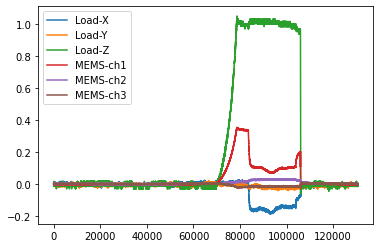

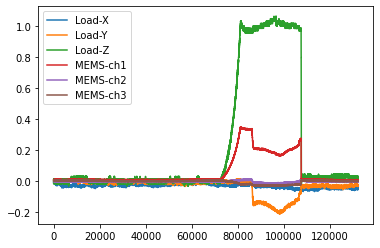

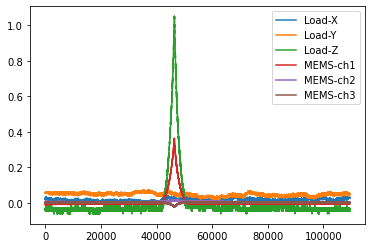

In [3]:
# 計測データの確認
move_x_df.plot()
move_y_df.plot()
move_z_df.plot()
# move_xyz_df.plot()

### ローバスフィルタの関数定義

In [4]:
def lowpass(x, samplerate):
    fp = 1                         # 通過域端周波数[Hz]
    fs = 40                         # 阻止域端周波数[Hz]
    gpass = 1                       # 通過域最大損失量[dB]
    gstop = 40                      # 阻止域最小減衰量[dB]

    # dfをarrayに
    x_array = x.values

    # 時系列のサンプルデータ作成

    n = len(x_array[:, 0])                         # データ数
    dt = 1/samplerate                       # サンプリング間隔
    fn = 1/(2*dt)                   # ナイキスト周波数

    column_num = len(x_array[0, :])

    #print('t=',t)
    data_lp = np.array([[0]*column_num for i in range(n)], dtype='float32')

    # 正規化
    Wp = fp/fn
    Ws = fs/fn

    # ローパスフィルタで波形整形
    # バターワースフィルタ
    N, Wn = signal.buttord(Wp, Ws, gpass, gstop)
    b1, a1 = signal.butter(N, Wn, "low")

    for i in range(column_num):
      data_lp[:, i] = signal.filtfilt(b1, a1, x_array[:, i])

    return pd.DataFrame(data=data_lp, columns=x.columns)

### データの前処理

In [5]:
def pre_process(target_base_df):
  # MEMSとロードセル分離
  mems_df = target_base_df.filter(regex='MEMS-ch+', axis=1)
  load_df = target_base_df.filter(regex='Load-+', axis=1)

  # MEMSに風袋処理
  mems_calib_df = mems_df - mems_df[10000:11000].mean()

  # ローパスフィルタ適応
  mems_lp_df = lowpass(mems_calib_df, NI_SAMPLE_RATE)
  load_lp_df = lowpass(load_df, NI_SAMPLE_RATE)

  # 全ての前処理を完了した全データのセット
  return pd.concat([load_lp_df, mems_lp_df], axis=1)

In [6]:
# 全計測データに対して前処理
pp_x_df = pre_process(move_x_df)
pp_y_df = pre_process(move_y_df)
pp_z_df = pre_process(move_z_df)
pp_xyz_df = pre_process(move_xyz_df)

### 有効範囲のデータのみ切り出し

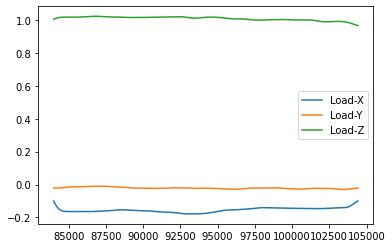

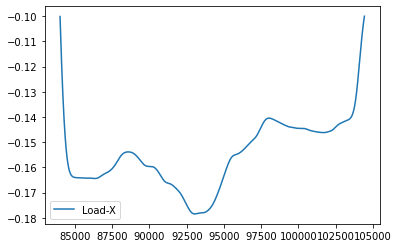

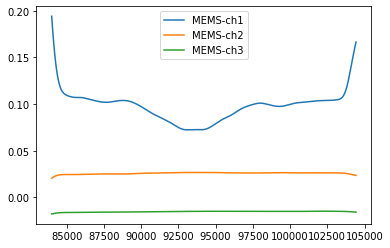

In [7]:
valid_x_df = pp_x_df[(pp_x_df['Load-X'] < -0.1)]
valid_x_df.filter(regex='Load-+').plot()
valid_x_df.filter(regex='Load-X').plot()
valid_x_df.filter(regex='MEMS-ch+').plot()

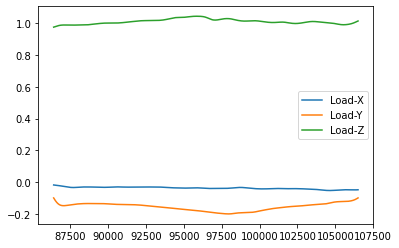

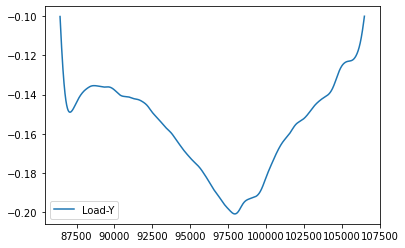

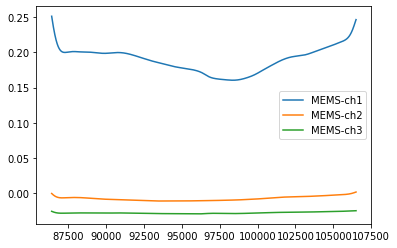

In [8]:
# 計測時に移動させた軸のロードセル荷重データが一定以上変化している部分を抜き出す
valid_y_df = pp_y_df[(pp_y_df['Load-Y'] < -0.1)]
valid_y_df.filter(regex='Load-+').plot()
valid_y_df.filter(regex='Load-Y').plot()
valid_y_df.filter(regex='MEMS-ch+').plot()

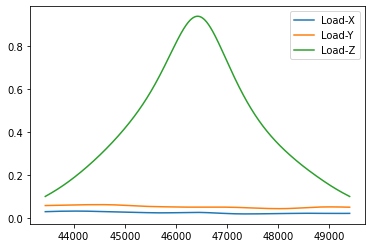

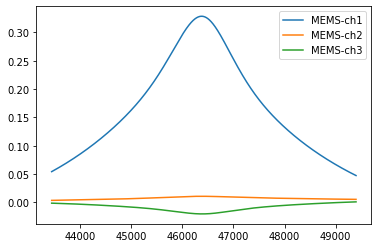

In [9]:
valid_z_df = pp_z_df[(pp_z_df['Load-Z'] > 0.1)]
valid_z_df.filter(regex='Load-+').plot()
valid_z_df.filter(regex='MEMS-ch+').plot()

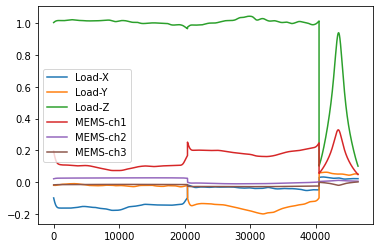

In [10]:
# 切り出したそれぞれのデータを一つに結合
valid_df = pd.concat([valid_x_df, valid_y_df, valid_z_df], axis=0, ignore_index=True)
valid_df.plot()

### モデル構築

In [11]:
# 線形回帰モデルの構築
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(
    valid_df.filter(regex='MEMS-ch+'),
    valid_df.filter(regex='Load-+')
    )

# 求まった係数（変換行列）
linear_reg.coef_

array([[  0.6336506 ,  -4.3456492 ,   6.8169327 ],
       [  0.65243363,   2.2434058 ,   9.31728   ],
       [ -0.16775165,  15.074757  , -41.286163  ]], dtype=float32)

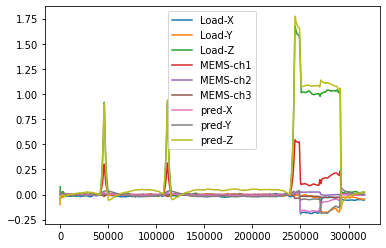

In [12]:
pred_a = linear_reg.predict(pp_xyz_df.filter(regex='MEMS-ch+'))
pred_df = pd.DataFrame(pred_a, columns=['pred-X', 'pred-Y', 'pred-Z'])
result_mix_df = pd.concat([pp_xyz_df, pred_df], axis=1)
result_mix_df.plot()

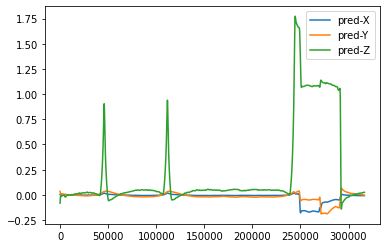

In [13]:
result_mix_df.filter(regex='pred-+').plot()

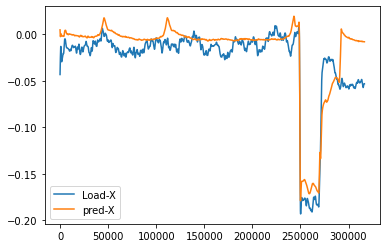

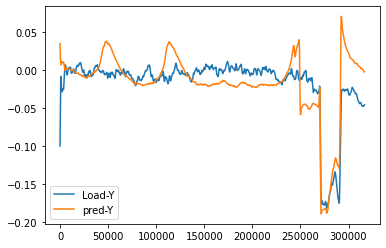

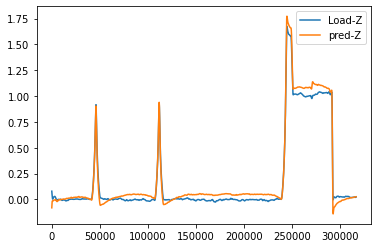

In [14]:
result_mix_df.filter(regex='-X$').plot()
result_mix_df.filter(regex='-Y$').plot()
result_mix_df.filter(regex='-Z$').plot()